In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from camera_properties_loader import CameraPropertiesLoader
import vpi

In [81]:
img_path = "/media/devansh/T7 Shield/wildfire_thermal/2.images/gascola_1/images_raw_synced/861.png"
img_raw = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

left_raw, right_raw = np.split(img_raw, 2, axis=1)

# print image shape, dtype
print(img_raw.shape)
print(img_raw.dtype)

(512, 1280)
uint16


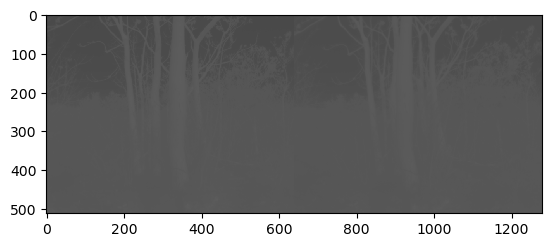

In [82]:
img_8_scaled = np.uint8(img_raw / 256.0)
# visualize image
plt.imshow(cv2.cvtColor(img_8_scaled.astype(np.uint8), cv2.COLOR_GRAY2RGB))

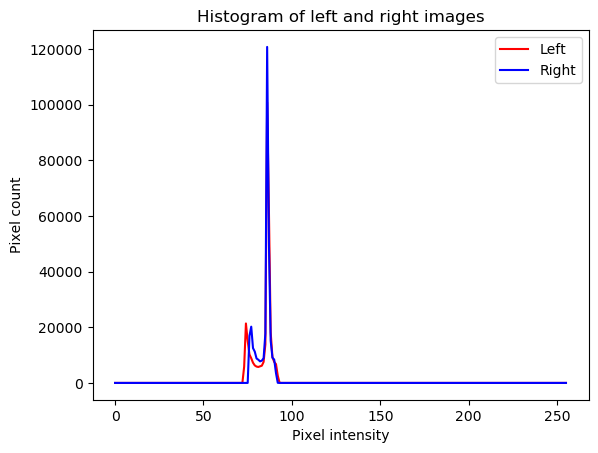

In [83]:
# plot histogram of left and right images as 2 separate line plots
plt.figure()
plt.plot(np.histogram(left_raw, bins=2**8, range=(0,(2**16)-1))[0], color='r')
plt.plot(np.histogram(right_raw, bins=2**8, range=(0,(2**16)-1))[0], color='b')
plt.xlabel('Pixel intensity')
plt.ylabel('Pixel count')
plt.title('Histogram of left and right images')
plt.legend(['Left', 'Right'])
plt.show()

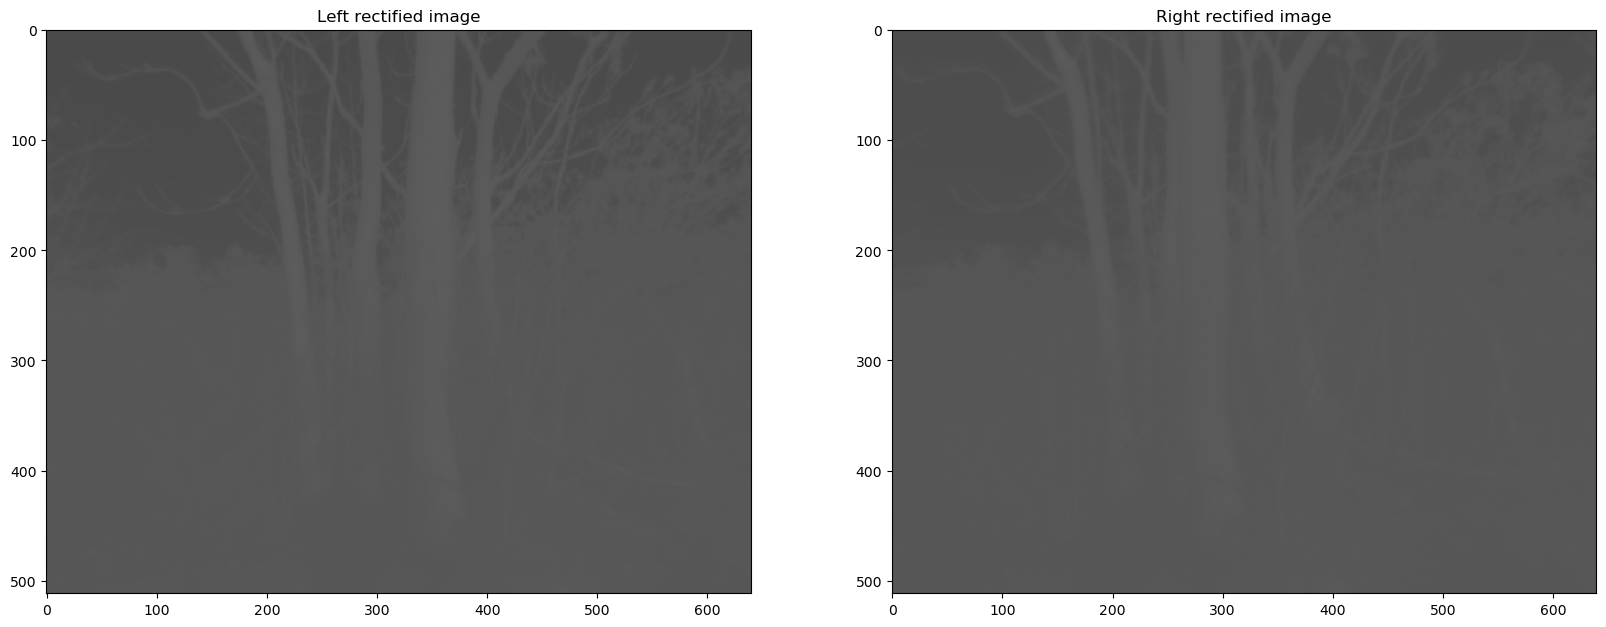

In [84]:
# rectify images
left_camera_properties = CameraPropertiesLoader('./thermal_left.yaml')
right_camera_properties = CameraPropertiesLoader('./thermal_right.yaml')

K_left, D_left, R_left, t_left = left_camera_properties.get_properties()
K_right, D_right, R_right, t_right = right_camera_properties.get_properties()

R = np.dot(R_right, R_left.T)  # Rotation matrix
T = t_right - np.dot(R, t_left)  # Translation vector

baseline = np.abs(T[1])
focal_length = (K_left[0][0] + K_left[1][1]) / 2

image_size = left_raw.shape[1], left_raw.shape[0]

# Compute the rectification maps
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K_left, D_left, K_right, D_right, image_size, R, T
)

map1x, map1y = cv2.initUndistortRectifyMap(
    K_left, D_left, R1, P1, image_size, cv2.CV_32FC1
)
map2x, map2y = cv2.initUndistortRectifyMap(
    K_right, D_right, R2, P2, image_size, cv2.CV_32FC1
)

left_rectified_16 = cv2.remap(
    left_raw, map1x, map1y, cv2.INTER_LINEAR
)
right_rectified_16 = cv2.remap(
    right_raw, map2x, map2y, cv2.INTER_LINEAR
)

left_rectified_8 = np.uint8(left_rectified_16 / 256.0)
right_rectified_8 = np.uint8(right_rectified_16 / 256.0)

# 2 subplots, 1 row, 2 columns (left, right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(left_rectified_8, cv2.COLOR_GRAY2RGB))
ax1.set_title('Left rectified image')
ax2.imshow(cv2.cvtColor(right_rectified_8, cv2.COLOR_GRAY2RGB))
ax2.set_title('Right rectified image')
plt.show()

In [85]:
def compute_ncc(left_patch, right_patch):
    if left_patch.shape != right_patch.shape:
        raise ValueError("Left and right patches must have the same shape")
    
    if left_patch.ndim != 2:
        raise ValueError("Left and right patches must be 2D arrays")
    
    # Compute the mean of each patch
    left_mean = np.mean(left_patch)
    right_mean = np.mean(right_patch)
    
    # Compute the standard deviation of each patch
    left_std = np.std(left_patch)
    right_std = np.std(right_patch)

    # Handle cases where standard deviation is close to zero
    left_std = max(left_std, 1e-10)
    right_std = max(right_std, 1e-10)

    # Compute the normalized cross-correlation
    ncc = np.sum((left_patch - left_mean) * (right_patch - right_mean)) / (left_std * right_std * left_patch.size) + 1e-10
    return ncc

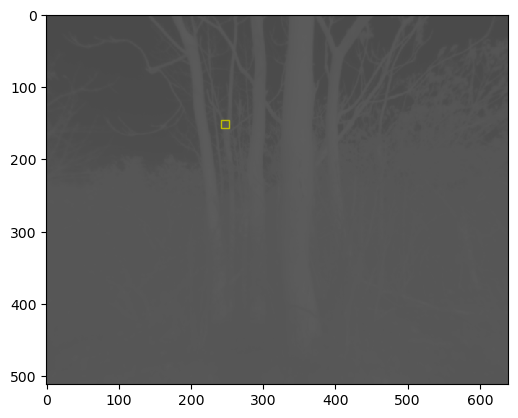

In [86]:
# select point in left image
left_point = (247, 150)
window_size = 5
left_patch = left_rectified_8[
    left_point[1] - window_size : left_point[1] + window_size + 1,
    left_point[0] - window_size : left_point[0] + window_size + 1
]
# visualize left point and patch as x and yellow bbox respectively
plt.imshow(cv2.cvtColor(left_rectified_8, cv2.COLOR_GRAY2RGB))
# plt.plot(left_point[0], left_point[1], 'rx')
plt.gca().add_patch(
    plt.Rectangle(
        (left_point[0] - window_size, left_point[1] - window_size),
        2 * window_size + 1,
        2 * window_size + 1,
        linewidth=1,
        edgecolor='y',
        facecolor='none'
    )
)
plt.show()

In [87]:
def epipolar_matching(left_point, left_image, right_image, window_size):
    left_patch = left_image[
        left_point[1] - window_size : left_point[1] + window_size + 1,
        left_point[0] - window_size : left_point[0] + window_size + 1
        ]
    # compute NCC for all points along the same row in the right image
    right_y = left_point[1]
    stride_size = 1
    ncc_values = []

    right_padded = np.pad(
        right_image,
        ((window_size, window_size), (window_size, window_size)),
        'constant'
    )

    for right_x in range(window_size, right_padded.shape[1] - window_size, stride_size):
        right_patch = right_padded[
            right_y - window_size : right_y + window_size + 1,
            right_x - window_size : right_x + window_size + 1
        ]
        ncc_values.append([right_x, compute_ncc(left_patch, right_patch)])

    ncc_values = np.array(ncc_values)
    # print(ncc_values.shape)
    # visualize NCC values
    # plt.plot(ncc_values[:, 0], ncc_values[:, 1])
    # plt.xlabel('x coordinate')
    # plt.ylabel('NCC value')
    # plt.title('NCC along epipolar line in the right image')
    # plt.show()
    return ncc_values

ncc_values = epipolar_matching(left_point, left_rectified_8, right_rectified_8, window_size)

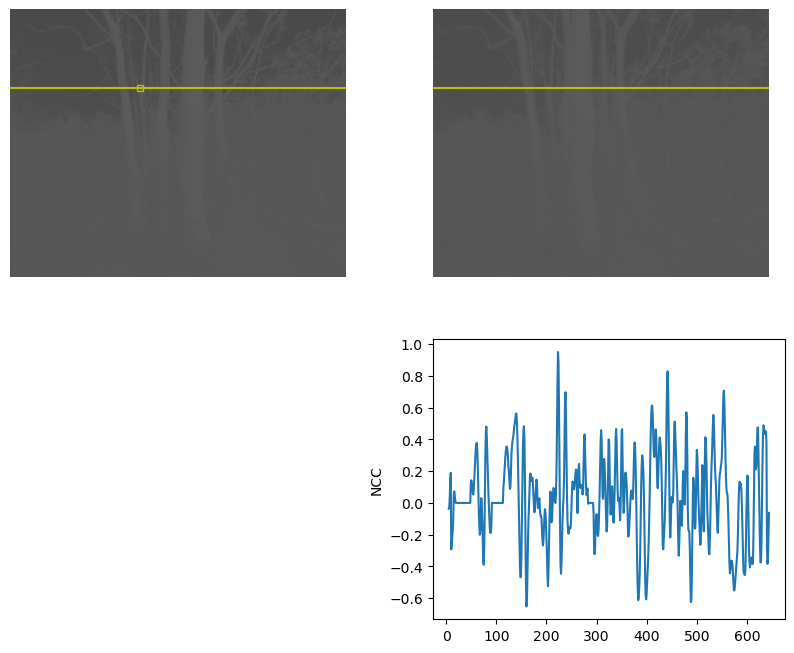

In [88]:
def display_ncc_results(left_point, ncc_values, left_rectified_8, right_rectified_8, window_size):
    # plot left, right image side by side. Remove axis ticks and labels
    fig = plt.figure(figsize=(10, 8)) 
    fig.add_subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(left_rectified_8, cv2.COLOR_GRAY2RGB))
    plt.axis('off')
    # plot left patch on left image
    plt.gca().add_patch(
        plt.Rectangle(
            (left_point[0] - window_size, left_point[1] - window_size),
            2 * window_size + 1,
            2 * window_size + 1,
            linewidth=1,
            edgecolor='y',
            facecolor='none'
        )
    )
    # plot epipolar line
    plt.plot([0, right_rectified_8.shape[1]], [left_point[1], left_point[1]], 'y')

    fig.add_subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(right_rectified_8, cv2.COLOR_GRAY2RGB))
    plt.axis('off')
    plt.plot([0, right_rectified_8.shape[1]], [left_point[1], left_point[1]], 'y')

    fig.add_subplot(2, 2, 3)
    # create blank white image of same size as left image
    blank_image = np.ones_like(left_rectified_8) * 255
    plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_GRAY2RGB))
    plt.axis('off')

    # Create a new axis for the NCC plot below the right image
    fig.add_subplot(2, 2, 4)
    plt.plot(ncc_values[:, 0], ncc_values[:, 1])
    plt.ylabel('NCC')
    # # size of the NCC plot should be the same as the right image
    # plt.xlim([0, right_rectified_8.shape[1]])
    # plt.ylim([0, 1])
    # plt.tight_layout()

    plt.show()

display_ncc_results(left_point, ncc_values, left_rectified_8, right_rectified_8, window_size)

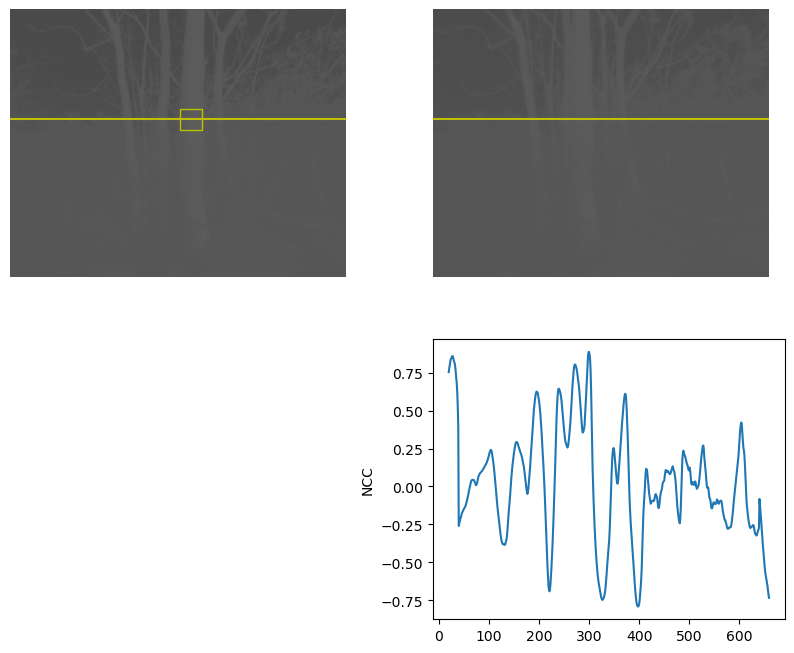

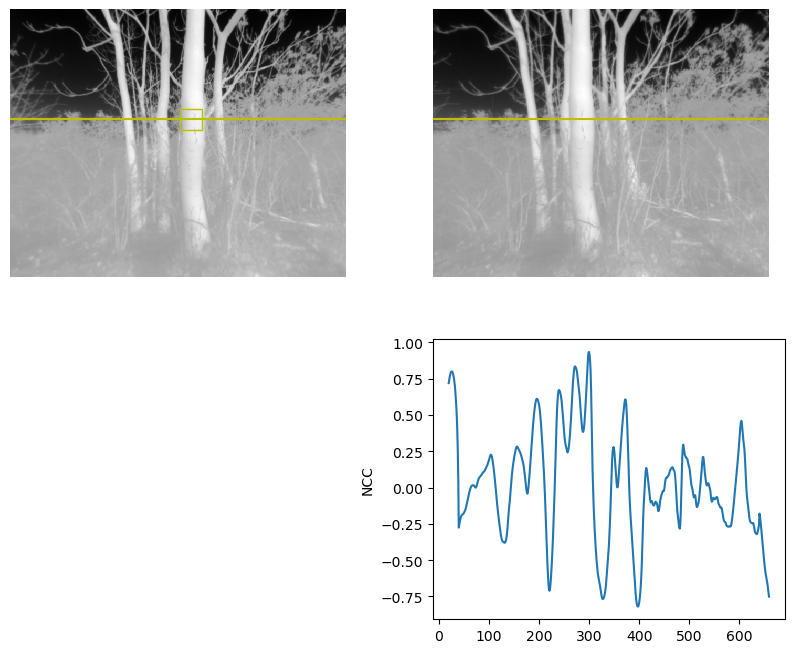

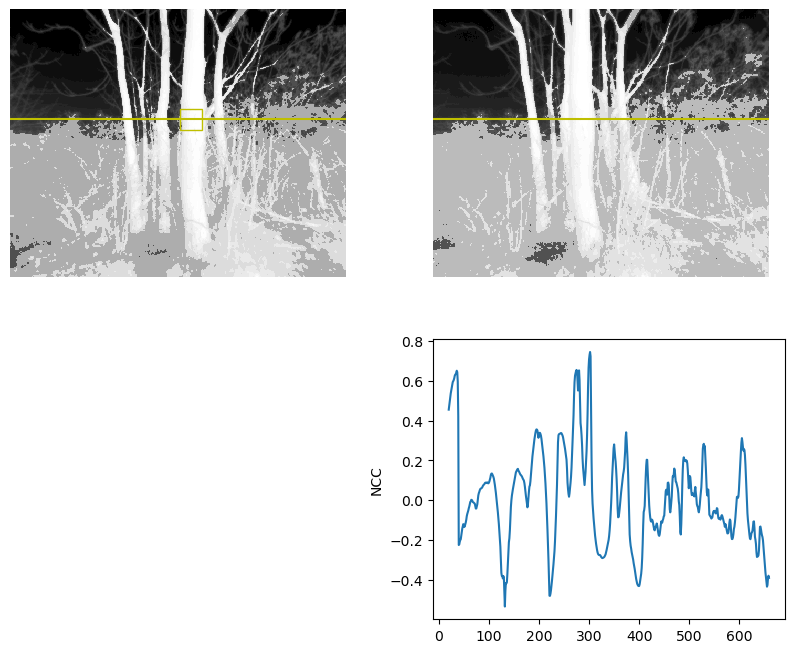

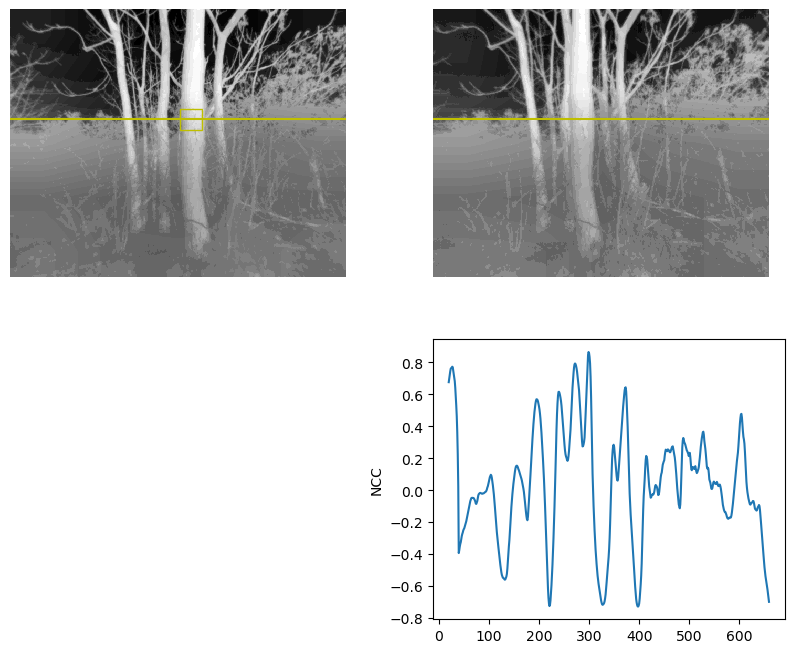

In [97]:
left_point = (345, 210)
window_size = 20

# raw image
ncc_raw = epipolar_matching(left_point, left_rectified_8, right_rectified_8, window_size)
display_ncc_results(left_point, ncc_raw, left_rectified_8, right_rectified_8, window_size)

# min-max normalize image
left_minmax = cv2.normalize(left_rectified_16, None, 0, 255, cv2.NORM_MINMAX)
right_minmax = cv2.normalize(right_rectified_16, None, 0, 255, cv2.NORM_MINMAX)
ncc_minmax = epipolar_matching(left_point, left_minmax, right_minmax, window_size)
display_ncc_results(left_point, ncc_minmax, left_minmax, right_minmax, window_size)

# histogram equalization
left_histequi = cv2.equalizeHist(left_rectified_8)
right_histequi = cv2.equalizeHist(right_rectified_8)
ncc_histequi = epipolar_matching(left_point, left_histequi, right_histequi, window_size)
display_ncc_results(left_point, ncc_histequi, left_histequi, right_histequi, window_size)

# use clahe to enhance contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(5, 5))
left_clahe = clahe.apply(left_rectified_8)
right_clahe = clahe.apply(right_rectified_8)
left_clahe = cv2.normalize(left_clahe, None, 0, 255, cv2.NORM_MINMAX)
right_clahe = cv2.normalize(right_clahe, None, 0, 255, cv2.NORM_MINMAX)

ncc_clahe = epipolar_matching(left_point, left_clahe, right_clahe, window_size)
display_ncc_results(left_point, ncc_clahe, left_clahe, right_clahe, window_size)